# Прогнозирование удовлетворённости клиентов авиакомпании

Задача: спрогнозировать удовлетворённость клиентов авиакомпании.

Результаты:

1. Наилучший прогноз построен с использованием алгоритма CatBoostClassifier. 
2. Наилучшая достигнутая метрика f1_score = 0.9596
3. Наиболее важные для прогноза признаки: Inflight wifi service, Type of Travel, Online boarding.

Какие данные используем: данные содержат результаты опроса клиентов авиакомпании по поводу удовлетворённости полётом. 

Признаки в данных

- Gender — пол пассажира (женский, мужской);
- Customer Type — тип клиента (постоянный/непостоянный клиент);
- Age — возраст клиента;
- Type of Travel — цель перелета (личная/деловая поездка);
- Class — туристический класс пассажира (Business, Eco, Eco Plus);
- Flight distance — расстояние полета;
- Inflight wifi service — уровень удовлетворённости Wi-Fi (0 — не применимо, 1–5);
- Departure/Arrival time convenient — уровень удовлетворённости временем отправления и прибытия;
- Ease of Online booking — уровень удовлетворённости онлайн-бронированием;
- Gate location — уровень удовлетворённости расположением выхода на посадку;
- Food and drink — уровень удовлетворённости едой и напитками;
- Online boarding — уровень удовлетворённости онлайн-регистрацией;
- Seat comfort — уровень удовлетворённости комфортом сидений;
- Inflight entertainment — уровень удовлетворённости развлечениями на борту;
- On-board service — уровень удовлетворённости сервисом на борту;
- Leg room service — уровень удовлетворённости местом для ног;
- Baggage handling — уровень удовлетворённости обработкой багажа;
- Check-in service — уровень удовлетворённости услугами регистрации;
- Inflight service — уровень удовлетворённости обслуживанием во время полёта;
- Cleanliness — уровень удовлетворённости чистотой;
- Departure Delay in Minutes — задержка при отправлении (в минутах);
- Arrival Delay in Minutes — задержка при прибытии (в минутах);
- Satisfaction — удовлетворённость авиакомпанией — целевая переменная (satisfaction/neutral/dissatisfaction).

In [1]:
#!pip install xgboost
#!pip install catboost

In [67]:
#Импорт необходимых библиотек и модулей
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import Pool, CatBoostClassifier
from catboost.utils import get_confusion_matrix

## Первичное исследование данных

In [68]:
data = pd.read_csv('AirPass.csv')
data.drop('Unnamed: 0', axis=1, inplace=True) #Удаление неинформативного столбца в данных
data.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## Работа с пропусками в данных

In [69]:
# Сколько в данных пропущенных значений
print('Всего пропущенных значений:', data.isna().sum().sum()) #Всего пропущенных значений
data.isna().sum() #Пропуски по каждому признаку

Всего пропущенных значений: 310


id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [5]:
#Пропуски есть только в столбце 'Arrival Delay in Minutes'. 
#Заполним их медианным значением.

data['Arrival Delay in Minutes'].fillna(data['Arrival Delay in Minutes'].median(), inplace=True)
data.isna().sum()

id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

In [6]:
data['Arrival Delay in Minutes'].mean()

15.133392362180475

In [7]:
#Ещё раз посмотрим на данные и определим типы
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   Gender                             103904 non-null  object 
 2   Customer Type                      103904 non-null  object 
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  object 
 5   Class                              103904 non-null  object 
 6   Flight Distance                    103904 non-null  int64  
 7   Inflight wifi service              103904 non-null  int64  
 8   Departure/Arrival time convenient  103904 non-null  int64  
 9   Ease of Online booking             103904 non-null  int64  
 10  Gate location                      103904 non-null  int64  
 11  Food and drink                     1039

## Исследовательский анализ данных

Проведём небольшой разведывательный анализ. Посмотрим, в каких категориях пассажиров превалировали удовлетворённые полетом клиенты.

1. Сравним удовлетворённость полётом мужчин и женщин. 
2. Сравним категории пассажиров в зависимости от их цели поездки. 
3. В каком туристическом классе наибольший процент довольных клиентов?


In [8]:
#Оценим, какие значения есть в признаке удовлетворённости и сколько их
data['satisfaction'].value_counts()

neutral or dissatisfied    58879
satisfied                  45025
Name: satisfaction, dtype: int64

In [9]:
#Сравним удовлетворённость полётом мужчин и женщин.
pivot1 = pd.pivot_table(data,
               index=['Gender','satisfaction'],
               values='id',
               aggfunc='count'
              )
pivot1

id
Gender satisfaction                  
Female neutral or dissatisfied  30193
       satisfied                22534
Male   neutral or dissatisfied  28686
       satisfied                22491

Text(0, 0.5, 'Количество')

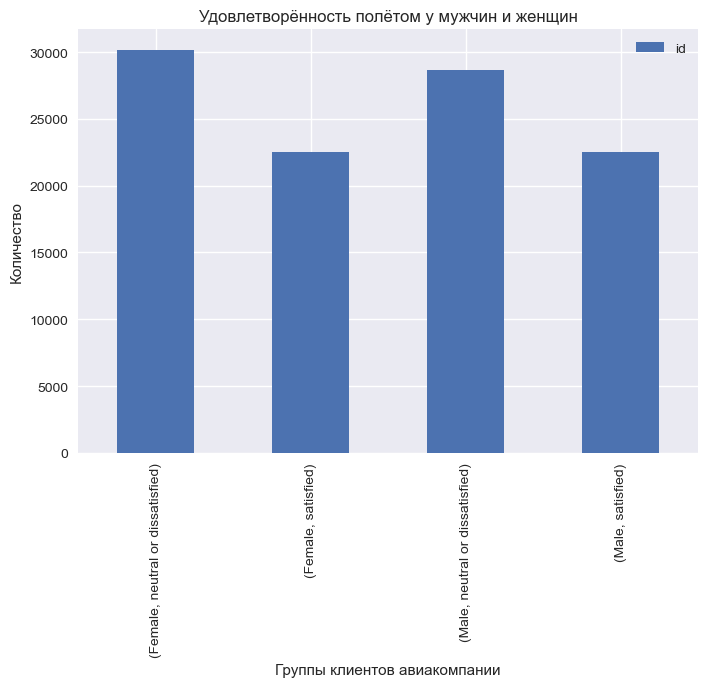

In [10]:
#Визуализируем сводные данные
pivot1.plot(kind='bar');
plt.title('Удовлетворённость полётом у мужчин и женщин')
plt.xlabel('Группы клиентов авиакомпании')
plt.ylabel('Количество')

In [11]:
#Сравним категории пассажиров в зависимости от их цели поездки.
pivot2 = pd.pivot_table(data,
               index=['Type of Travel','satisfaction'],
               values='id',
               aggfunc='count'
              )
pivot2

id
Type of Travel  satisfaction                  
Business travel neutral or dissatisfied  29909
                satisfied                41746
Personal Travel neutral or dissatisfied  28970
                satisfied                 3279

Text(0, 0.5, 'Количество')

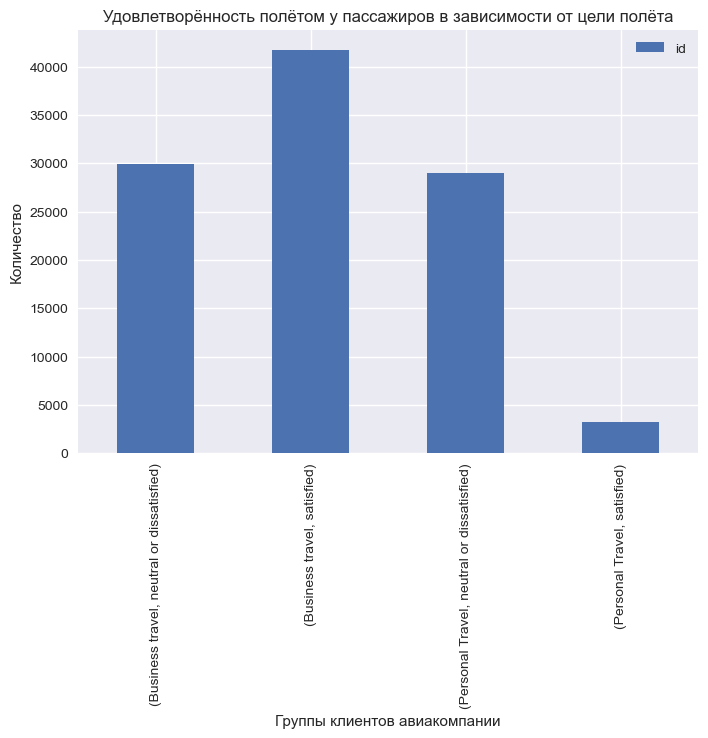

In [12]:
#Визуализируем сводные данные
pivot2.plot(kind='bar');
plt.title('Удовлетворённость полётом у пассажиров в зависимости от цели полёта')
plt.xlabel('Группы клиентов авиакомпании')
plt.ylabel('Количество')

In [13]:
#В каком туристическом классе наибольший процент довольных клиентов?
pivot3 = pd.pivot_table(data,
               index=['Class','satisfaction'],
               values='id',
               aggfunc='count'
              )
pivot3

id
Class    satisfaction                  
Business neutral or dissatisfied  15185
         satisfied                34480
Eco      neutral or dissatisfied  38044
         satisfied                 8701
Eco Plus neutral or dissatisfied   5650
         satisfied                 1844

Text(0, 0.5, 'Количество')

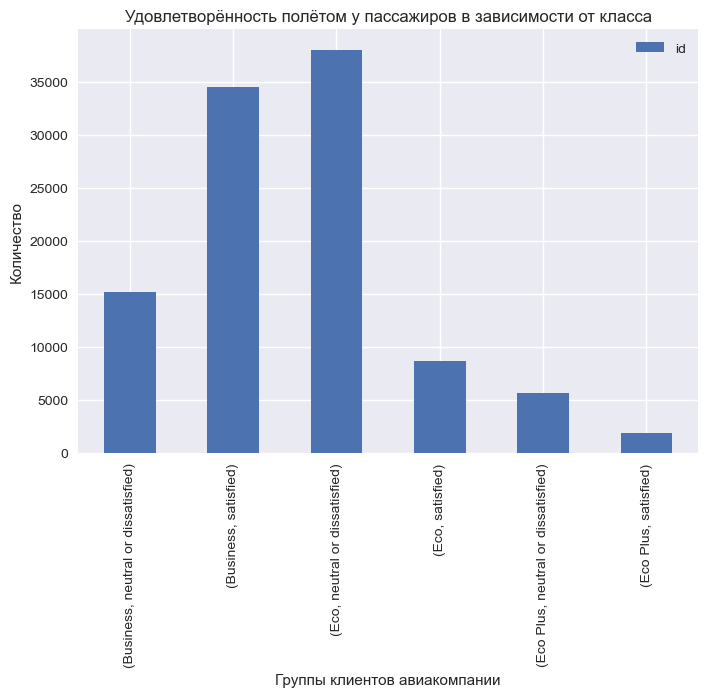

In [14]:
#Визуализируем сводные данные
pivot3.plot(kind='bar');
plt.title('Удовлетворённость полётом у пассажиров в зависимости от класса')
plt.xlabel('Группы клиентов авиакомпании')
plt.ylabel('Количество')

## Преобразование данных

Перекодируем часть бинарных признаков, включая таргет, чтобы использовать их при обучении:

In [15]:
data['satisfaction'] = data['satisfaction'].map({'neutral or dissatisfied':0 , 'satisfied':1})
data['Customer Type'] = data['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
data['Type of Travel'] = data['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})

Для остальных категориальных признаков создадим dummy-переменные. Сделаем это с помощью функции get_dummies() из библиотеки Pandas с параметрами по умолчанию. 

In [16]:
data = pd.get_dummies(data)
data.head()

,id,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,...,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Gender_Female,Gender_Male,Class_Business,Class_Eco,Class_Eco Plus
0,70172,1,13,0,460,3,4,3,1,5,...,5,5,25,18.0,0,0,1,0,0,1
1,5047,0,25,1,235,3,2,3,3,1,...,4,1,1,6.0,0,0,1,1,0,0
2,110028,1,26,1,1142,2,2,2,2,5,...,4,5,0,0.0,1,1,0,1,0,0
3,24026,1,25,1,562,2,5,5,5,2,...,4,2,11,9.0,0,1,0,1,0,0
4,119299,1,61,1,214,3,3,3,3,4,...,3,3,0,0.0,1,0,1,1,0,0


## Создание тестовой и обучающей выборок

Разобьём данные на обучающую и тестовую выборки в соотношении 80/20, параметр random_state = 26. Оценим, сколько наблюдений попало в тестовую выборку?

In [17]:
X = data.drop('satisfaction', axis=1)
y = data['satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)
X_test.shape[0]

20781

## Стандартизация признаков

Используем StandardScaler

In [18]:
scaler = StandardScaler()
scaler.fit(X_train) #Обучаем скалер на тренировочных данных
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
#Посмотрим на стандартизированные тестовые данные
X_test_scaled

array([[ 0.94082514,  0.47381845,  0.37290362, ...,  1.04624209,
        -0.90523003, -0.27897268],
       [-0.86687265,  0.47381845,  1.49930106, ...,  1.04624209,
        -0.90523003, -0.27897268],
       [-1.63303947, -2.11051299, -1.15104586, ..., -0.95580173,
         1.10469159, -0.27897268],
       ...,
       [ 1.52620083, -2.11051299, -1.15104586, ..., -0.95580173,
         1.10469159, -0.27897268],
       [-0.60330678,  0.47381845,  0.83671433, ..., -0.95580173,
         1.10469159, -0.27897268],
       [ 1.34108544,  0.47381845, -0.02464842, ...,  1.04624209,
        -0.90523003, -0.27897268]])

## Модель логистической регрессии

Используем параметры по умолчанию и определяем метрику f1_score

In [26]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_test_pred = lr.predict(X_test_scaled)
f1_score(y_test, y_test_pred)

0.8546883773161146

## Модель AdaBoost

Обучим модель AdaBoost, зафиксировав random_state со значением 26 и задав темп обучения 0.01. Определим значение метрики f1_score. 

In [70]:
abc = AdaBoostClassifier(DecisionTreeClassifier(random_state=26), random_state=26, learning_rate=0.01)
abc.fit(X_train, y_train)
y_test_pred = abc.predict(X_test)
f1_score(y_test, y_test_pred)

0.9401681226306248

## Модель градиентного бустинга

Будем настраивать количество деревьев и темп обучения, делая перебор по следующей сетке:

params = {"n_estimators":2 ** np.arange(8), "learning_rate":0.1 ** np.arange(3)}

Используем для поиска оптимальных параметров GridSearchCV, а для ускорения работы алгоритма зададим параметр кросс-валидации, равный 3.

Какое наибольшее значение метрики f1_score получилось? Примечание. Необходимо указать лучший результат в методе GridSearchCV на тренировочных данных.

In [71]:
params = {"n_estimators": 2**np.arange(8), "learning_rate": 0.1**np.arange(3)}

estimator = GradientBoostingClassifier()
grid = GridSearchCV(estimator, 
                  params, 
                  cv=3, 
                  scoring=make_scorer(f1_score),
                  verbose=5)

grid.fit(X_train, y_train)

print("Лучшие гиперпараметры:", grid.best_params_)
print("Лучшее значение метрики:", grid.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END .learning_rate=1.0, n_estimators=1;, score=0.873 total time=   0.0s
[CV 2/3] END .learning_rate=1.0, n_estimators=1;, score=0.870 total time=   0.0s
[CV 3/3] END .learning_rate=1.0, n_estimators=1;, score=0.871 total time=   0.0s
[CV 1/3] END .learning_rate=1.0, n_estimators=2;, score=0.880 total time=   0.1s
[CV 2/3] END .learning_rate=1.0, n_estimators=2;, score=0.878 total time=   0.1s
[CV 3/3] END .learning_rate=1.0, n_estimators=2;, score=0.875 total time=   0.1s
[CV 1/3] END .learning_rate=1.0, n_estimators=4;, score=0.901 total time=   0.3s
[CV 2/3] END .learning_rate=1.0, n_estimators=4;, score=0.896 total time=   0.3s
[CV 3/3] END .learning_rate=1.0, n_estimators=4;, score=0.897 total time=   0.3s
[CV 1/3] END .learning_rate=1.0, n_estimators=8;, score=0.920 total time=   0.6s
[CV 2/3] END .learning_rate=1.0, n_estimators=8;, score=0.920 total time=   0.7s
[CV 3/3] END .learning_rate=1.0, n_estimators=8;

## Модель XGBClassifier

Установить random_state = 26. Какое значение метрики f1_score получилось?

In [72]:
xgbc = XGBClassifier(random_state=26)
xgbc.fit(X_train, y_train)
y_test_pred = xgbc.predict(X_test)
f1_score(y_test, y_test_pred)

C:\Users\agner\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:43:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9579785161685312

## Модель CatBoostClassifier

Используем настройки по умолчанию.

In [73]:
cbc = CatBoostClassifier(random_state = 26)
cbc.fit(X_train, y_train)
y_test_pred = cbc.predict(X_test)
f1_score(y_test, y_test_pred)

Learning rate set to 0.068023
0:	learn: 0.6008195	total: 10.2ms	remaining: 10.2s
1:	learn: 0.5274385	total: 21.6ms	remaining: 10.8s
2:	learn: 0.4526910	total: 31.4ms	remaining: 10.4s
3:	learn: 0.4085048	total: 40.7ms	remaining: 10.1s
4:	learn: 0.3754338	total: 51.1ms	remaining: 10.2s
5:	learn: 0.3316906	total: 63.2ms	remaining: 10.5s
6:	learn: 0.3110786	total: 74ms	remaining: 10.5s
7:	learn: 0.2929212	total: 84.8ms	remaining: 10.5s
8:	learn: 0.2731866	total: 95.2ms	remaining: 10.5s
9:	learn: 0.2584983	total: 105ms	remaining: 10.4s
10:	learn: 0.2433967	total: 116ms	remaining: 10.4s
11:	learn: 0.2327963	total: 128ms	remaining: 10.5s
12:	learn: 0.2245690	total: 137ms	remaining: 10.4s
13:	learn: 0.2158971	total: 148ms	remaining: 10.4s
14:	learn: 0.2073527	total: 158ms	remaining: 10.4s
15:	learn: 0.1986440	total: 169ms	remaining: 10.4s
16:	learn: 0.1921241	total: 179ms	remaining: 10.3s
17:	learn: 0.1881224	total: 188ms	remaining: 10.3s
18:	learn: 0.1841775	total: 199ms	remaining: 10.3s
19:	

178:	learn: 0.0904540	total: 1.9s	remaining: 8.73s
179:	learn: 0.0904002	total: 1.91s	remaining: 8.72s
180:	learn: 0.0903026	total: 1.92s	remaining: 8.71s
181:	learn: 0.0902174	total: 1.93s	remaining: 8.69s
182:	learn: 0.0900486	total: 1.94s	remaining: 8.68s
183:	learn: 0.0899208	total: 1.95s	remaining: 8.66s
184:	learn: 0.0898839	total: 1.96s	remaining: 8.65s
185:	learn: 0.0898198	total: 1.97s	remaining: 8.63s
186:	learn: 0.0897596	total: 1.98s	remaining: 8.62s
187:	learn: 0.0896785	total: 1.99s	remaining: 8.61s
188:	learn: 0.0895971	total: 2s	remaining: 8.61s
189:	learn: 0.0889656	total: 2.02s	remaining: 8.59s
190:	learn: 0.0888383	total: 2.02s	remaining: 8.58s
191:	learn: 0.0886414	total: 2.04s	remaining: 8.57s
192:	learn: 0.0885536	total: 2.04s	remaining: 8.55s
193:	learn: 0.0884065	total: 2.05s	remaining: 8.54s
194:	learn: 0.0883030	total: 2.06s	remaining: 8.52s
195:	learn: 0.0882218	total: 2.07s	remaining: 8.51s
196:	learn: 0.0880479	total: 2.08s	remaining: 8.49s
197:	learn: 0.08

342:	learn: 0.0769632	total: 3.59s	remaining: 6.88s
343:	learn: 0.0768941	total: 3.6s	remaining: 6.87s
344:	learn: 0.0768225	total: 3.61s	remaining: 6.85s
345:	learn: 0.0767765	total: 3.62s	remaining: 6.84s
346:	learn: 0.0767453	total: 3.63s	remaining: 6.84s
347:	learn: 0.0767168	total: 3.64s	remaining: 6.83s
348:	learn: 0.0766582	total: 3.65s	remaining: 6.82s
349:	learn: 0.0766233	total: 3.66s	remaining: 6.81s
350:	learn: 0.0765154	total: 3.67s	remaining: 6.79s
351:	learn: 0.0764720	total: 3.68s	remaining: 6.78s
352:	learn: 0.0764046	total: 3.69s	remaining: 6.77s
353:	learn: 0.0763850	total: 3.7s	remaining: 6.76s
354:	learn: 0.0763318	total: 3.71s	remaining: 6.75s
355:	learn: 0.0763195	total: 3.72s	remaining: 6.73s
356:	learn: 0.0763037	total: 3.73s	remaining: 6.72s
357:	learn: 0.0762690	total: 3.74s	remaining: 6.71s
358:	learn: 0.0762566	total: 3.75s	remaining: 6.7s
359:	learn: 0.0762106	total: 3.76s	remaining: 6.69s
360:	learn: 0.0761279	total: 3.77s	remaining: 6.68s
361:	learn: 0.0

520:	learn: 0.0697779	total: 5.29s	remaining: 4.86s
521:	learn: 0.0697451	total: 5.3s	remaining: 4.85s
522:	learn: 0.0696863	total: 5.31s	remaining: 4.84s
523:	learn: 0.0696502	total: 5.32s	remaining: 4.83s
524:	learn: 0.0696135	total: 5.32s	remaining: 4.82s
525:	learn: 0.0695656	total: 5.33s	remaining: 4.81s
526:	learn: 0.0694657	total: 5.34s	remaining: 4.79s
527:	learn: 0.0694407	total: 5.35s	remaining: 4.78s
528:	learn: 0.0693514	total: 5.36s	remaining: 4.77s
529:	learn: 0.0693308	total: 5.37s	remaining: 4.76s
530:	learn: 0.0693204	total: 5.38s	remaining: 4.75s
531:	learn: 0.0692870	total: 5.39s	remaining: 4.74s
532:	learn: 0.0692615	total: 5.39s	remaining: 4.73s
533:	learn: 0.0692357	total: 5.4s	remaining: 4.71s
534:	learn: 0.0692169	total: 5.41s	remaining: 4.7s
535:	learn: 0.0692060	total: 5.42s	remaining: 4.69s
536:	learn: 0.0691943	total: 5.43s	remaining: 4.68s
537:	learn: 0.0691824	total: 5.44s	remaining: 4.67s
538:	learn: 0.0691402	total: 5.45s	remaining: 4.66s
539:	learn: 0.0

700:	learn: 0.0643218	total: 6.97s	remaining: 2.98s
701:	learn: 0.0642965	total: 6.99s	remaining: 2.97s
702:	learn: 0.0642720	total: 7s	remaining: 2.96s
703:	learn: 0.0642459	total: 7.01s	remaining: 2.95s
704:	learn: 0.0642113	total: 7.02s	remaining: 2.94s
705:	learn: 0.0641835	total: 7.03s	remaining: 2.93s
706:	learn: 0.0641456	total: 7.04s	remaining: 2.92s
707:	learn: 0.0641136	total: 7.04s	remaining: 2.9s
708:	learn: 0.0640787	total: 7.05s	remaining: 2.9s
709:	learn: 0.0640474	total: 7.06s	remaining: 2.88s
710:	learn: 0.0640089	total: 7.07s	remaining: 2.87s
711:	learn: 0.0639794	total: 7.08s	remaining: 2.86s
712:	learn: 0.0639456	total: 7.09s	remaining: 2.85s
713:	learn: 0.0639308	total: 7.1s	remaining: 2.84s
714:	learn: 0.0639116	total: 7.11s	remaining: 2.83s
715:	learn: 0.0638757	total: 7.12s	remaining: 2.82s
716:	learn: 0.0638301	total: 7.13s	remaining: 2.81s
717:	learn: 0.0638076	total: 7.13s	remaining: 2.8s
718:	learn: 0.0637803	total: 7.14s	remaining: 2.79s
719:	learn: 0.06376

859:	learn: 0.0602492	total: 8.46s	remaining: 1.38s
860:	learn: 0.0602255	total: 8.47s	remaining: 1.37s
861:	learn: 0.0601935	total: 8.48s	remaining: 1.36s
862:	learn: 0.0601805	total: 8.49s	remaining: 1.35s
863:	learn: 0.0601441	total: 8.49s	remaining: 1.34s
864:	learn: 0.0601168	total: 8.5s	remaining: 1.33s
865:	learn: 0.0600950	total: 8.51s	remaining: 1.32s
866:	learn: 0.0600751	total: 8.52s	remaining: 1.31s
867:	learn: 0.0600677	total: 8.53s	remaining: 1.3s
868:	learn: 0.0600514	total: 8.54s	remaining: 1.29s
869:	learn: 0.0600426	total: 8.55s	remaining: 1.28s
870:	learn: 0.0600316	total: 8.55s	remaining: 1.27s
871:	learn: 0.0600070	total: 8.56s	remaining: 1.26s
872:	learn: 0.0599752	total: 8.57s	remaining: 1.25s
873:	learn: 0.0599599	total: 8.58s	remaining: 1.24s
874:	learn: 0.0599558	total: 8.59s	remaining: 1.23s
875:	learn: 0.0599481	total: 8.6s	remaining: 1.22s
876:	learn: 0.0599386	total: 8.61s	remaining: 1.21s
877:	learn: 0.0599133	total: 8.62s	remaining: 1.2s
878:	learn: 0.05

0.9596173100456113

## Построение Confusion Matrix для лучшего алгоритма



In [74]:
cm = get_confusion_matrix(cbc, Pool(X_train, y_train))
print(cm)

[[46685.   521.]
 [ 1289. 34628.]]


## Оценка важности признаков

In [75]:
fi = pd.DataFrame({'feature_importance': cbc.get_feature_importance(), 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], ascending=False)
fi

,feature_importance,feature_names
5,24.878354,Inflight wifi service
3,18.814038,Type of Travel
10,7.379155,Online boarding
1,7.175333,Customer Type
23,5.041700,Class_Business
16,4.118206,Checkin service
2,3.442092,Age
15,3.369730,Baggage handling
8,3.359879,Gate location
11,3.182827,Seat comfort


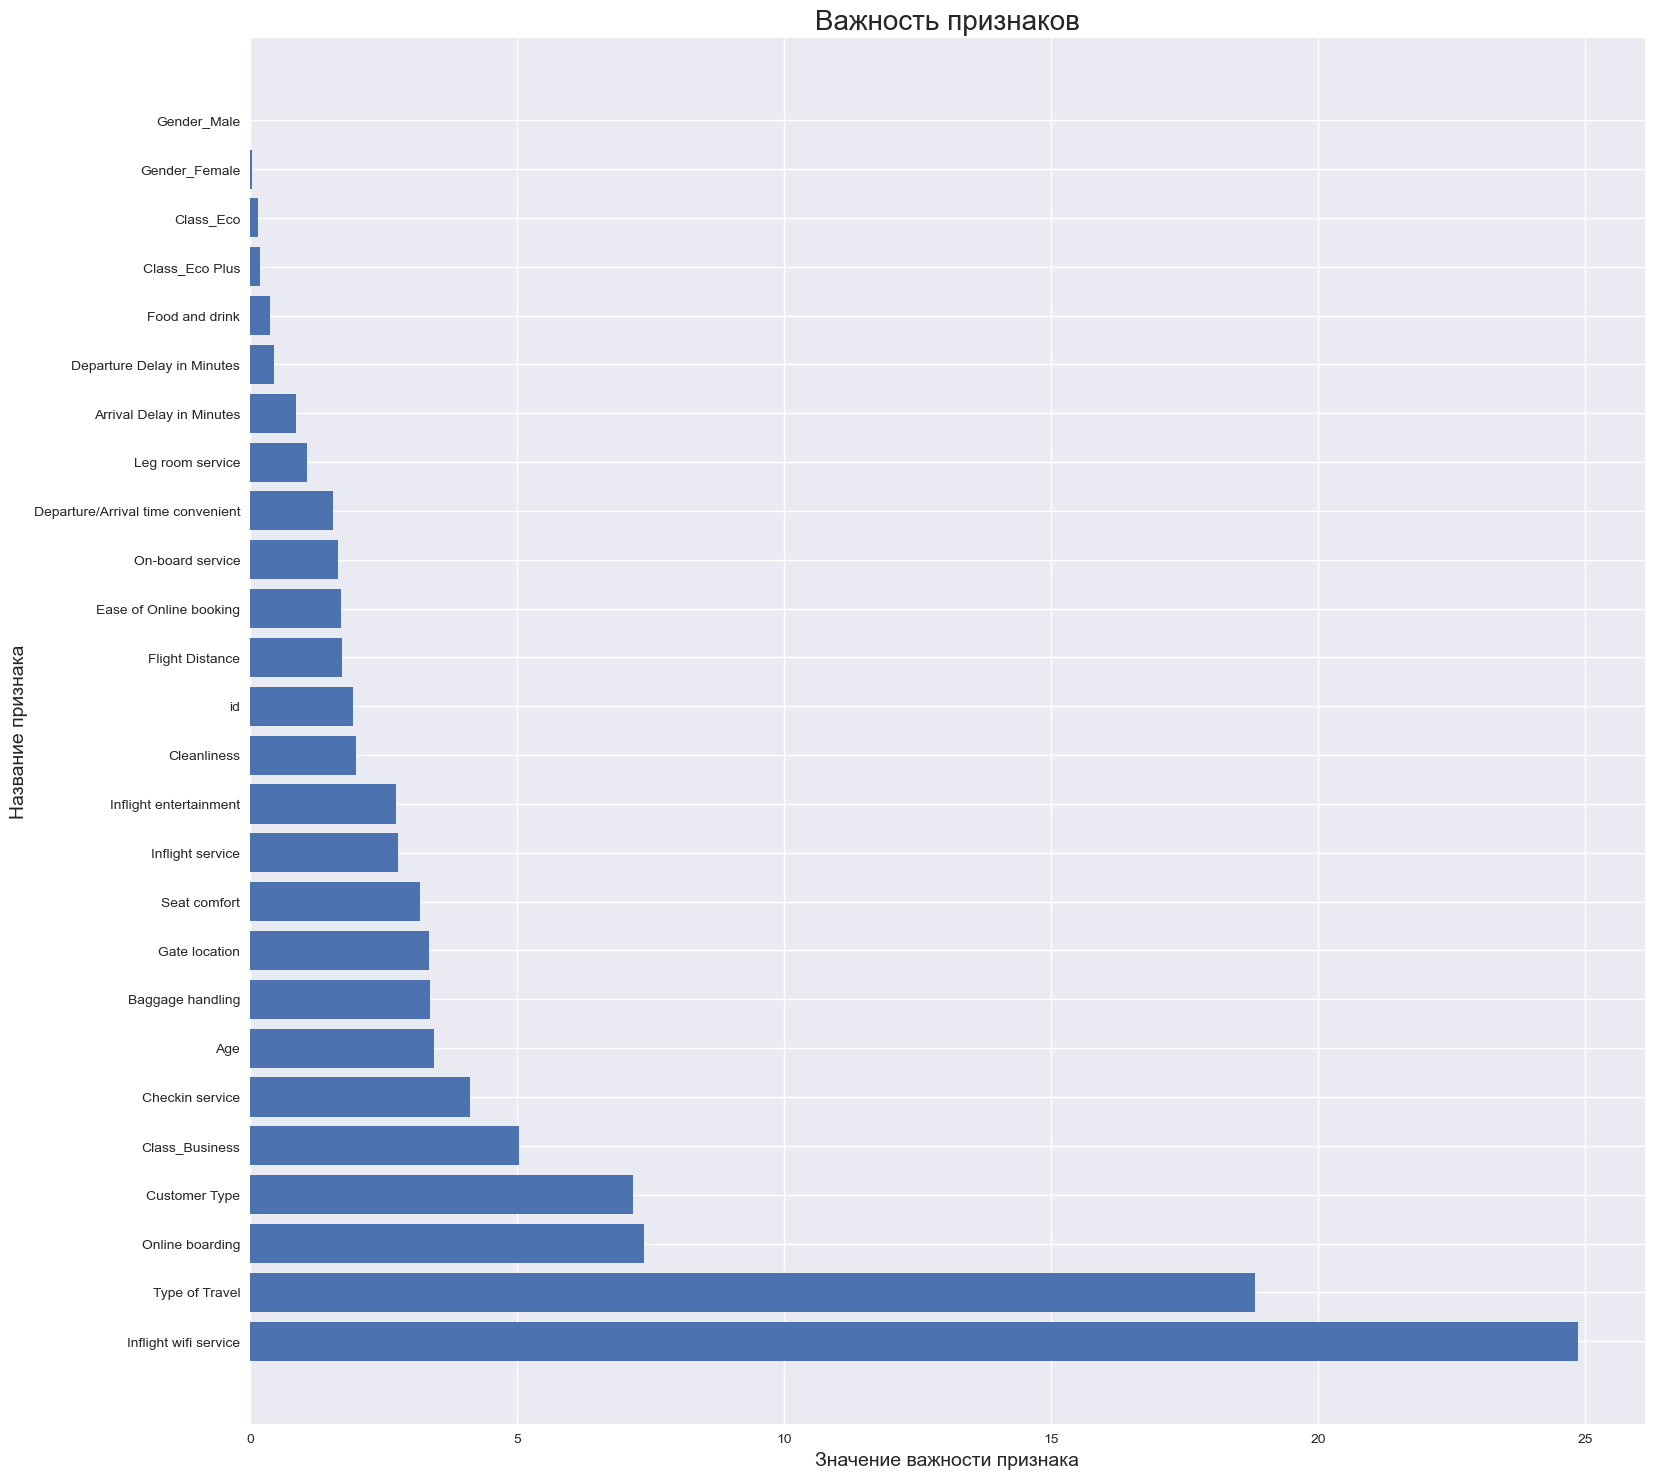

In [76]:
# Визулизируем важность признаков:
fig = plt.figure(figsize=(18,18))

plt.barh(fi['feature_names'], fi['feature_importance']);
plt.title('Важность признаков', fontsize=20);
plt.xlabel('Значение важности признака', fontsize=14);
plt.ylabel('Название признака', fontsize=14);